In [120]:
import pandas as pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# Data Preparation


In [121]:
#Read data
df0 = pd.read_csv("2015_S2.csv", sep = ";")
df1 = pd.read_csv("2016_S1.csv", sep = ";")
df2 = pd.read_csv("2016_S2.csv", sep = ";")
df3 = pd.read_csv("2017_S1.csv", sep = ";")
df4 = pd.read_csv("2017_S2.csv", sep = ";")
df5 = pd.read_csv("2018_S1.csv", sep = ";")
df6 = pd.read_csv("2018_S2.csv", sep = ";")
df7 = pd.read_csv("2019_S1.csv", sep = ";")
df8 = pd.read_csv("2019_S2.csv", sep = ";")

data0 = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)

In [123]:
# Function converting scenario to one_hot
def scenario_one_hot(data):
    #extract numeric data from scenario 'S1' to '1' 
    data['scenario_num'] = data['scenario'].str.extract('(\d+)')
    data.drop(['scenario'], axis=1, inplace=True)
    
    #add one-hot encoding to scenario: 
    scenario = pd.get_dummies(data['scenario_num'], prefix = 'scenario', dummy_na=True)
    data1= pd.concat([data, scenario], axis=1)
    return data1 

#test: 
# data= scenario_one_hot(data)

In [124]:
# Functions to make cyclical data into continuous data using cos & sin
def smooth_wind_dir(data):
    data['cos_wind_dir'] = np.cos(2*np.pi*data['wind_dir']/360)
    data['sin_wind_dir'] = np.sin(2*np.pi*data['wind_dir']/360)
    data.drop(['wind_dir'], axis=1, inplace=True)
    return data 

def smooth_hour(data):
    #split '00h00' to two columns of numeric values
    hour=data['hour'].str.split(pat='h', expand=True)
    hour = hour.apply(pd.to_numeric, errors='coerce')
    
    #calculate minutes passed since 00h00 
    hour['minutes'] = 60*hour[0]+hour[1]
    hour['cos_hour'] = np.cos(2*np.pi*hour['minutes']/(60*24)) 
    hour['sin_hour'] = np.sin(2*np.pi*hour['minutes']/(60*24)) 

    #concat and update dataframe
    data = pd.concat([data, hour[['cos_hour','sin_hour']]], axis=1)
    data.drop(['hour'], axis=1, inplace=True)  
    return data

# Smooth date 
def smooth_day(data):
    # Convert day to date-time 
    data['day'] = pd.to_datetime(data['day'],format='%d/%m/%Y')
    data['day_delta'] = pd.to_numeric(data['day']-data['day'][0])
    # Calculate time delta since 1st entry 
    data['day_delta'] 
    data['cos_day'] = np.cos(2*np.pi*data['day_delta']/(365)) 
    data['sin_day'] = np.sin(2*np.pi*data['day_delta']/(365))
    data.drop(['day_delta'], axis=1, inplace=True)
    return data 

# Testing: 
# data=smooth_wind_dir(data)
# data= smooth_hour(data)
# data=smooth_day(data)
# data.head()

,day,speed,temp,details,radiation,precip,scenario_num,scenario_1,scenario_2,scenario_3,scenario_4,scenario_nan,cos_wind_dir,sin_wind_dir,cos_hour,sin_hour,cos_day,sin_day
0,2015-07-01,2.6,20.7,mesure,0.0,0.0,1,1,0,0,0,0,0.788011,0.615661,1.000000,0.000000,1.0,0.0
1,2015-07-01,2.0,20.7,mesure,0.0,0.0,1,1,0,0,0,0,0.719340,0.694658,0.997859,0.065403,1.0,0.0
2,2015-07-01,1.8,20.7,mesure,0.0,0.0,1,1,0,0,0,0,0.998630,-0.052336,0.991445,0.130526,1.0,0.0
3,2015-07-01,2.5,20.8,mesure,0.0,0.0,1,1,0,0,0,0,0.913545,-0.406737,0.980785,0.195090,1.0,0.0
4,2015-07-01,2.9,20.7,mesure,0.0,0.0,1,1,0,0,0,0,0.866025,-0.500000,0.965926,0.258819,1.0,0.0


In [ ]:
# Function to prepare data using above functions
def prepare_data(data0):
    #Interpolate missing values
    data = data0.interpolate()
    
    #scenario to one-hot encoding
    data= scenario_one_hot(data)
    
    #smooth wind_dir, hour, and day using cos & sin function 
    data=smooth_wind_dir(data)
    data= smooth_hour(data)
    data=smooth_day(data)
    
    return data 
    
data = prepare_data(data0)  

In [ ]:
# ------ OLD CODE UNTOUCHED ------- 

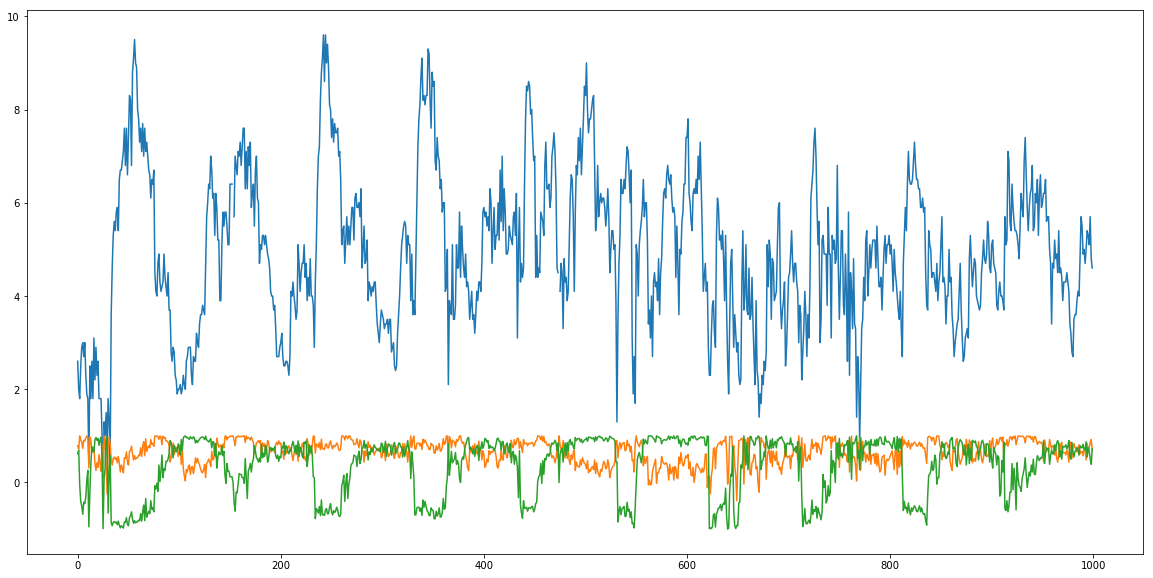

In [44]:
n = 1000
plt.plot(df["speed"].head(n))
plt.plot(df["cos_scaled"].head(n))
plt.plot(df["sin_scaled"].head(n))
#plt.figure(figsize=(40,40))
plt.rcParams["figure.figsize"] = (10,20)
plt.show()

In [9]:
y = df["speed"]
lag_plot(y)
pyplot.show()

NameError: name 'df' is not defined

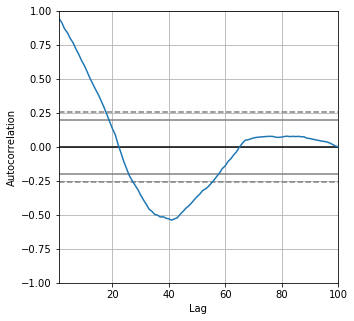

In [65]:
autocorrelation_plot(y.head(100))
plt.rcParams["figure.figsize"] = (5,5)
pyplot.show()

Test MSE: 0.120


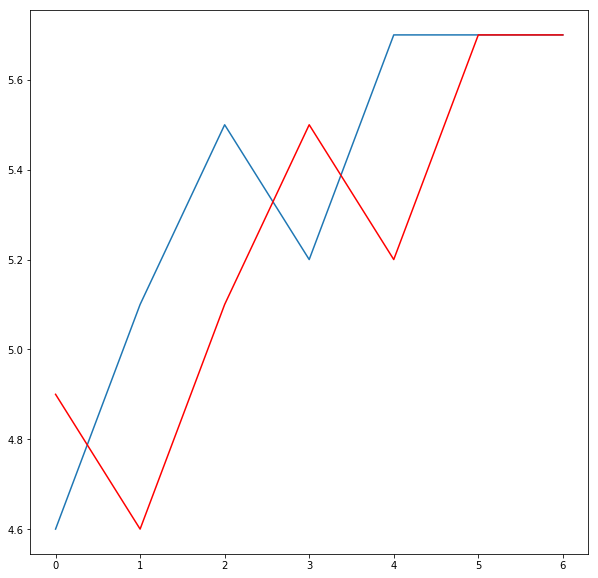

In [314]:
series = data.speed
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Lag: 75
Coefficients: [ 1.15845741e-01  8.54939077e-01  3.69066097e-02  3.19144434e-02
  1.57148965e-02  9.89786331e-03 -1.39713268e-04 -6.96727857e-03
 -7.38020355e-05  5.05316664e-03 -4.22690847e-03  1.00270264e-03
  3.38341768e-03 -8.17083661e-03 -3.30534677e-03  2.97181306e-03
  4.34260451e-03  2.86021860e-03  2.36364714e-03  4.46456649e-03
  1.56618941e-03 -9.09528208e-03  1.24522514e-03  4.91888314e-03
 -8.51147254e-03  2.25938127e-03  2.94842194e-03 -3.38077627e-03
  2.24185567e-03 -2.30787131e-03  2.81760294e-03  3.89001141e-03
  1.74730452e-04 -1.01089706e-02  5.26548459e-03  6.39499803e-03
 -6.53552997e-04 -5.80161823e-03 -3.94120887e-03 -4.42787165e-03
  4.66537561e-03  2.56353562e-03  1.23005530e-03 -4.20588949e-03
  5.24369413e-04 -5.23976868e-03  1.72378916e-03  2.80734016e-03
 -7.91001668e-03  2.48177047e-03  1.29945023e-03 -2.09869085e-03
 -1.35334491e-04  1.49735088e-03  2.69496569e-03  4.34537197e-04
 -2.81132949e-03 -1.88736112e-03  1.07638343e-03  3.29973423e-03
  1

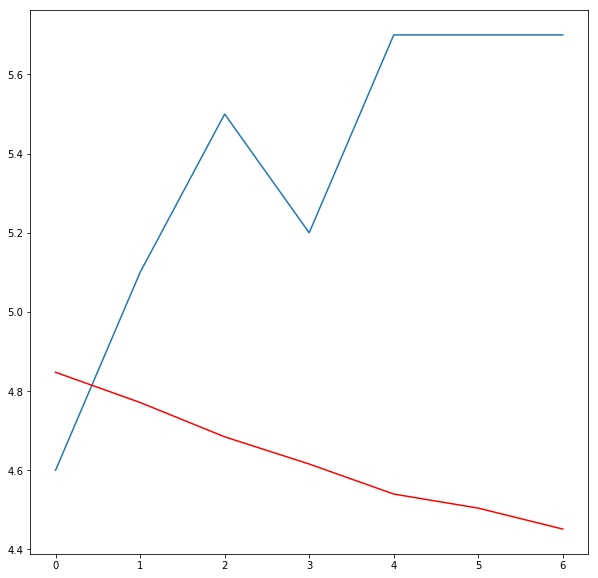

In [312]:
series = data.speed
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [310]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(y1, model='additive')
x = decomposed.plot() #See note below about this

AttributeError: 'Int64Index' object has no attribute 'inferred_freq'

predicted=5.444221, expected=6.200000
predicted=5.969262, expected=5.200000
predicted=5.196177, expected=5.200000
predicted=5.219058, expected=4.700000
predicted=4.727747, expected=5.400000
predicted=5.281308, expected=6.100000
predicted=5.891172, expected=6.300000
predicted=6.114362, expected=5.400000
predicted=5.351573, expected=5.300000
predicted=5.233812, expected=5.500000
predicted=5.411869, expected=5.200000
predicted=5.121331, expected=5.400000
predicted=5.259510, expected=5.300000
predicted=5.183133, expected=5.100000
predicted=5.028278, expected=5.300000
predicted=5.207626, expected=4.800000
predicted=4.783596, expected=4.900000
predicted=4.847548, expected=4.600000
predicted=4.559363, expected=5.100000
predicted=4.956511, expected=5.500000
predicted=5.317199, expected=5.200000
predicted=5.076144, expected=5.700000
predicted=5.546454, expected=5.700000
predicted=5.551073, expected=5.700000
Test MSE: 0.199


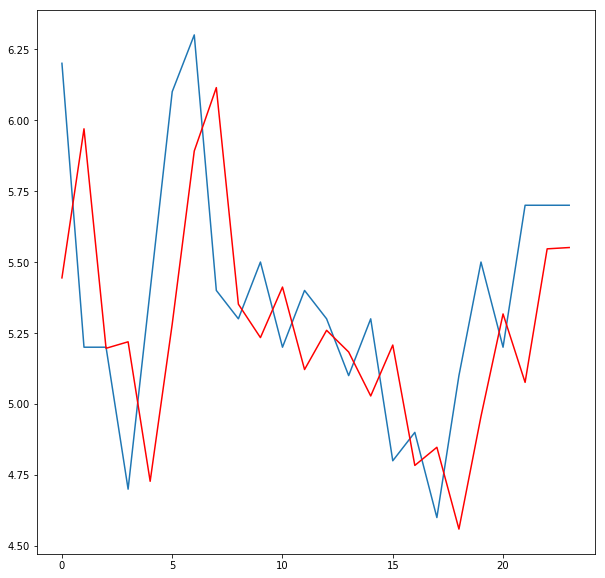

In [321]:
series = data["speed"]
# split dataset
X = series.values
train, test = X[1:len(X)-24], X[len(X)-24:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [11]:
df0 = pd.read_csv("2015_S2.csv", sep = ";")
df1 = pd.read_csv("2016_S1.csv", sep = ";")
df2 = pd.read_csv("2016_S2.csv", sep = ";")
df3 = pd.read_csv("2017_S1.csv", sep = ";")
df4 = pd.read_csv("2017_S2.csv", sep = ";")
df5 = pd.read_csv("2018_S1.csv", sep = ";")
df6 = pd.read_csv("2018_S2.csv", sep = ";")
df7 = pd.read_csv("2019_S1.csv", sep = ";")
df8 = pd.read_csv("2019_S2.csv", sep = ";")

In [12]:
data = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)

In [13]:
data = data.interpolate()

In [14]:
data["cos_wind_dir"] = np.cos(2*np.pi*data.wind_dir/360)
data["sin_wind_dir"] = np.sin(2*np.pi*data.wind_dir/360)

In [15]:
data.head(2140).tail(10)

,day,hour,wind_dir,speed,temp,details,scenario,radiation,precip,cos_wind_dir,sin_wind_dir
2130,23/07/2015,04h30,77.0,6.0,23.60,mesure,S1,0.0,0.0,0.224951,0.974370
2131,23/07/2015,04h45,70.0,4.9,23.40,mesure,S1,0.0,0.0,0.342020,0.939693
2132,23/07/2015,05h00,61.0,5.9,23.40,mesure,S1,0.0,0.0,0.484810,0.874620
2133,23/07/2015,05h15,69.0,5.1,23.10,mesure,S1,0.0,0.0,0.358368,0.933580
2134,23/07/2015,05h30,35.0,3.9,22.90,mesure,S1,0.0,0.0,0.819152,0.573576
2135,23/07/2015,05h45,52.0,3.9,22.75,NaN,NaN,3.0,0.0,0.615661,0.788011
2136,23/07/2015,06h00,69.0,3.9,22.60,mesure,S1,6.0,0.0,0.358368,0.933580
2137,23/07/2015,06h15,62.0,4.3,22.60,mesure,S1,17.0,0.0,0.469472,0.882948
2138,23/07/2015,06h30,71.0,3.1,22.80,mesure,S1,31.0,0.0,0.325568,0.945519
2139,23/07/2015,06h45,65.0,2.9,23.10,mesure,S1,49.0,0.0,0.422618,0.906308


In [293]:
data.head(2140).tail(10)

,day,hour,wind_dir,speed,temp,details,scenario,radiation,precip,cos_wind_dir,sin_wind_dir
2130,23/07/2015,04h30,77.0,6.0,23.6,mesure,S1,0.0,0.0,0.224951,0.974370
2131,23/07/2015,04h45,70.0,4.9,23.4,mesure,S1,0.0,0.0,0.342020,0.939693
2132,23/07/2015,05h00,61.0,5.9,23.4,mesure,S1,0.0,0.0,0.484810,0.874620
2133,23/07/2015,05h15,69.0,5.1,23.1,mesure,S1,0.0,0.0,0.358368,0.933580
2134,23/07/2015,05h30,35.0,3.9,22.9,mesure,S1,0.0,0.0,0.819152,0.573576
2135,23/07/2015,05h45,NaN,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2136,23/07/2015,06h00,69.0,3.9,22.6,mesure,S1,6.0,0.0,0.358368,0.933580
2137,23/07/2015,06h15,62.0,4.3,22.6,mesure,S1,17.0,0.0,0.469472,0.882948
2138,23/07/2015,06h30,71.0,3.1,22.8,mesure,S1,31.0,0.0,0.325568,0.945519
2139,23/07/2015,06h45,65.0,2.9,23.1,mesure,S1,49.0,0.0,0.422618,0.906308


In [296]:
pd.isna(data['wind_dir'][2135])

True

In [303]:
df = data["wind_dir"].interpolate()

In [304]:
df[2135]

52.0

In [289]:
data["speed"][2135] + 10 >= 10
data["speed"][2135] = (data["speed"][2136]+data["speed"][2134])/2
data["speed"][2135] + 10 >= 10

/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


True

In [276]:
s = data["speed"]
s.interpolate(method='linear', axis=0)

0         2.6
1         2.0
2         1.8
3         2.5
4         2.9
         ... 
152059    5.5
152060    5.2
152061    5.7
152062    5.7
152063    5.7
Name: speed, Length: 152064, dtype: float64

In [277]:
s[2130:2140]

2130    6.0
2131    4.9
2132    5.9
2133    5.1
2134    3.9
2135    NaN
2136    3.9
2137    4.3
2138    3.1
2139    2.9
Name: speed, dtype: float64

In [269]:
s.loc[2135] + 10 == s.loc[2135]

False

In [254]:
s[2236]

nan

0         2.6
1         2.0
2         1.8
3         2.5
4         2.9
         ... 
152059    5.5
152060    5.2
152061    5.7
152062    5.7
152063    5.7
Name: speed, Length: 152064, dtype: float64

In [272]:
s = data.speed
for i in range(20000,40000):
    t = s[i]
    e = type(s[i])
    if type(t) != e or type(t) != 'float' :
        print(t, e, i)

3.5 <class 'numpy.float64'> 20000
3.4 <class 'numpy.float64'> 20001
3.3 <class 'numpy.float64'> 20002
3.3 <class 'numpy.float64'> 20003
3.2 <class 'numpy.float64'> 20004
3.1 <class 'numpy.float64'> 20005
3.0 <class 'numpy.float64'> 20006
3.0 <class 'numpy.float64'> 20007
3.2 <class 'numpy.float64'> 20008
3.3 <class 'numpy.float64'> 20009
2.8 <class 'numpy.float64'> 20010
2.9 <class 'numpy.float64'> 20011
3.0 <class 'numpy.float64'> 20012
2.4 <class 'numpy.float64'> 20013
2.1 <class 'numpy.float64'> 20014
2.0 <class 'numpy.float64'> 20015
0.2 <class 'numpy.float64'> 20016
1.4 <class 'numpy.float64'> 20017
2.3 <class 'numpy.float64'> 20018
3.3 <class 'numpy.float64'> 20019
2.6 <class 'numpy.float64'> 20020
2.4 <class 'numpy.float64'> 20021
2.6 <class 'numpy.float64'> 20022
2.8 <class 'numpy.float64'> 20023
2.2 <class 'numpy.float64'> 20024
2.2 <class 'numpy.float64'> 20025
2.0 <class 'numpy.float64'> 20026
1.8 <class 'numpy.float64'> 20027
1.7 <class 'numpy.float64'> 20028
1.6 <class 'nu

4.4 <class 'numpy.float64'> 20634
4.6 <class 'numpy.float64'> 20635
5.2 <class 'numpy.float64'> 20636
4.8 <class 'numpy.float64'> 20637
5.7 <class 'numpy.float64'> 20638
5.7 <class 'numpy.float64'> 20639
4.3 <class 'numpy.float64'> 20640
3.9 <class 'numpy.float64'> 20641
4.5 <class 'numpy.float64'> 20642
5.0 <class 'numpy.float64'> 20643
4.7 <class 'numpy.float64'> 20644
4.6 <class 'numpy.float64'> 20645
5.5 <class 'numpy.float64'> 20646
5.2 <class 'numpy.float64'> 20647
5.4 <class 'numpy.float64'> 20648
6.1 <class 'numpy.float64'> 20649
4.5 <class 'numpy.float64'> 20650
2.2 <class 'numpy.float64'> 20651
4.0 <class 'numpy.float64'> 20652
5.1 <class 'numpy.float64'> 20653
5.3 <class 'numpy.float64'> 20654
6.0 <class 'numpy.float64'> 20655
5.3 <class 'numpy.float64'> 20656
5.8 <class 'numpy.float64'> 20657
6.5 <class 'numpy.float64'> 20658
6.4 <class 'numpy.float64'> 20659
5.9 <class 'numpy.float64'> 20660
6.3 <class 'numpy.float64'> 20661
6.5 <class 'numpy.float64'> 20662
6.5 <class 'nu

1.2 <class 'numpy.float64'> 21099
0.9 <class 'numpy.float64'> 21100
0.6 <class 'numpy.float64'> 21101
1.4 <class 'numpy.float64'> 21102
1.6 <class 'numpy.float64'> 21103
0.9 <class 'numpy.float64'> 21104
0.5 <class 'numpy.float64'> 21105
1.5 <class 'numpy.float64'> 21106
1.8 <class 'numpy.float64'> 21107
2.3 <class 'numpy.float64'> 21108
2.7 <class 'numpy.float64'> 21109
2.7 <class 'numpy.float64'> 21110
3.0 <class 'numpy.float64'> 21111
3.2 <class 'numpy.float64'> 21112
3.1 <class 'numpy.float64'> 21113
3.4 <class 'numpy.float64'> 21114
3.9 <class 'numpy.float64'> 21115
4.2 <class 'numpy.float64'> 21116
4.0 <class 'numpy.float64'> 21117
3.9 <class 'numpy.float64'> 21118
4.6 <class 'numpy.float64'> 21119
4.5 <class 'numpy.float64'> 21120
4.3 <class 'numpy.float64'> 21121
4.4 <class 'numpy.float64'> 21122
4.0 <class 'numpy.float64'> 21123
4.0 <class 'numpy.float64'> 21124
4.1 <class 'numpy.float64'> 21125
2.4 <class 'numpy.float64'> 21126
3.3 <class 'numpy.float64'> 21127
3.4 <class 'nu

2.0 <class 'numpy.float64'> 21615
2.1 <class 'numpy.float64'> 21616
2.5 <class 'numpy.float64'> 21617
2.2 <class 'numpy.float64'> 21618
2.1 <class 'numpy.float64'> 21619
2.3 <class 'numpy.float64'> 21620
2.0 <class 'numpy.float64'> 21621
2.2 <class 'numpy.float64'> 21622
2.2 <class 'numpy.float64'> 21623
2.4 <class 'numpy.float64'> 21624
2.2 <class 'numpy.float64'> 21625
2.1 <class 'numpy.float64'> 21626
1.9 <class 'numpy.float64'> 21627
1.9 <class 'numpy.float64'> 21628
1.9 <class 'numpy.float64'> 21629
2.1 <class 'numpy.float64'> 21630
2.0 <class 'numpy.float64'> 21631
2.2 <class 'numpy.float64'> 21632
1.9 <class 'numpy.float64'> 21633
2.4 <class 'numpy.float64'> 21634
2.0 <class 'numpy.float64'> 21635
2.1 <class 'numpy.float64'> 21636
2.5 <class 'numpy.float64'> 21637
2.6 <class 'numpy.float64'> 21638
2.4 <class 'numpy.float64'> 21639
2.9 <class 'numpy.float64'> 21640
2.9 <class 'numpy.float64'> 21641
2.0 <class 'numpy.float64'> 21642
2.5 <class 'numpy.float64'> 21643
2.6 <class 'nu

3.0 <class 'numpy.float64'> 22117
3.1 <class 'numpy.float64'> 22118
2.6 <class 'numpy.float64'> 22119
1.9 <class 'numpy.float64'> 22120
2.7 <class 'numpy.float64'> 22121
1.9 <class 'numpy.float64'> 22122
0.7 <class 'numpy.float64'> 22123
1.3 <class 'numpy.float64'> 22124
2.2 <class 'numpy.float64'> 22125
4.8 <class 'numpy.float64'> 22126
4.5 <class 'numpy.float64'> 22127
3.9 <class 'numpy.float64'> 22128
4.1 <class 'numpy.float64'> 22129
5.0 <class 'numpy.float64'> 22130
5.3 <class 'numpy.float64'> 22131
4.5 <class 'numpy.float64'> 22132
4.6 <class 'numpy.float64'> 22133
6.2 <class 'numpy.float64'> 22134
5.4 <class 'numpy.float64'> 22135
3.6 <class 'numpy.float64'> 22136
2.8 <class 'numpy.float64'> 22137
3.5 <class 'numpy.float64'> 22138
3.7 <class 'numpy.float64'> 22139
4.1 <class 'numpy.float64'> 22140
3.5 <class 'numpy.float64'> 22141
4.8 <class 'numpy.float64'> 22142
5.3 <class 'numpy.float64'> 22143
5.5 <class 'numpy.float64'> 22144
5.0 <class 'numpy.float64'> 22145
4.5 <class 'nu

4.7 <class 'numpy.float64'> 22634
5.5 <class 'numpy.float64'> 22635
3.6 <class 'numpy.float64'> 22636
3.0 <class 'numpy.float64'> 22637
3.4 <class 'numpy.float64'> 22638
3.4 <class 'numpy.float64'> 22639
0.9 <class 'numpy.float64'> 22640
0.6 <class 'numpy.float64'> 22641
2.8 <class 'numpy.float64'> 22642
3.1 <class 'numpy.float64'> 22643
3.7 <class 'numpy.float64'> 22644
4.0 <class 'numpy.float64'> 22645
3.4 <class 'numpy.float64'> 22646
3.4 <class 'numpy.float64'> 22647
2.8 <class 'numpy.float64'> 22648
2.2 <class 'numpy.float64'> 22649
2.1 <class 'numpy.float64'> 22650
1.6 <class 'numpy.float64'> 22651
2.7 <class 'numpy.float64'> 22652
2.0 <class 'numpy.float64'> 22653
1.7 <class 'numpy.float64'> 22654
2.1 <class 'numpy.float64'> 22655
5.1 <class 'numpy.float64'> 22656
6.8 <class 'numpy.float64'> 22657
4.6 <class 'numpy.float64'> 22658
6.0 <class 'numpy.float64'> 22659
3.2 <class 'numpy.float64'> 22660
4.5 <class 'numpy.float64'> 22661
6.2 <class 'numpy.float64'> 22662
5.8 <class 'nu

6.3 <class 'numpy.float64'> 23135
5.6 <class 'numpy.float64'> 23136
4.3 <class 'numpy.float64'> 23137
3.5 <class 'numpy.float64'> 23138
4.2 <class 'numpy.float64'> 23139
6.9 <class 'numpy.float64'> 23140
6.8 <class 'numpy.float64'> 23141
7.0 <class 'numpy.float64'> 23142
7.7 <class 'numpy.float64'> 23143
7.3 <class 'numpy.float64'> 23144
7.6 <class 'numpy.float64'> 23145
7.6 <class 'numpy.float64'> 23146
6.9 <class 'numpy.float64'> 23147
6.3 <class 'numpy.float64'> 23148
6.1 <class 'numpy.float64'> 23149
6.3 <class 'numpy.float64'> 23150
7.5 <class 'numpy.float64'> 23151
6.0 <class 'numpy.float64'> 23152
4.8 <class 'numpy.float64'> 23153
3.9 <class 'numpy.float64'> 23154
8.1 <class 'numpy.float64'> 23155
7.2 <class 'numpy.float64'> 23156
4.6 <class 'numpy.float64'> 23157
7.0 <class 'numpy.float64'> 23158
7.2 <class 'numpy.float64'> 23159
5.2 <class 'numpy.float64'> 23160
6.2 <class 'numpy.float64'> 23161
6.9 <class 'numpy.float64'> 23162
5.0 <class 'numpy.float64'> 23163
4.6 <class 'nu

5.1 <class 'numpy.float64'> 23620
5.3 <class 'numpy.float64'> 23621
4.4 <class 'numpy.float64'> 23622
4.7 <class 'numpy.float64'> 23623
4.5 <class 'numpy.float64'> 23624
4.9 <class 'numpy.float64'> 23625
5.0 <class 'numpy.float64'> 23626
4.8 <class 'numpy.float64'> 23627
3.5 <class 'numpy.float64'> 23628
3.2 <class 'numpy.float64'> 23629
4.0 <class 'numpy.float64'> 23630
4.1 <class 'numpy.float64'> 23631
4.2 <class 'numpy.float64'> 23632
3.9 <class 'numpy.float64'> 23633
4.3 <class 'numpy.float64'> 23634
4.5 <class 'numpy.float64'> 23635
4.3 <class 'numpy.float64'> 23636
5.2 <class 'numpy.float64'> 23637
5.1 <class 'numpy.float64'> 23638
5.3 <class 'numpy.float64'> 23639
5.1 <class 'numpy.float64'> 23640
4.7 <class 'numpy.float64'> 23641
4.5 <class 'numpy.float64'> 23642
4.1 <class 'numpy.float64'> 23643
4.0 <class 'numpy.float64'> 23644
4.1 <class 'numpy.float64'> 23645
4.9 <class 'numpy.float64'> 23646
4.8 <class 'numpy.float64'> 23647
5.4 <class 'numpy.float64'> 23648
6.3 <class 'nu

3.2 <class 'numpy.float64'> 24131
3.4 <class 'numpy.float64'> 24132
3.7 <class 'numpy.float64'> 24133
4.0 <class 'numpy.float64'> 24134
4.4 <class 'numpy.float64'> 24135
4.5 <class 'numpy.float64'> 24136
4.9 <class 'numpy.float64'> 24137
4.8 <class 'numpy.float64'> 24138
4.9 <class 'numpy.float64'> 24139
4.8 <class 'numpy.float64'> 24140
6.0 <class 'numpy.float64'> 24141
5.6 <class 'numpy.float64'> 24142
6.3 <class 'numpy.float64'> 24143
4.9 <class 'numpy.float64'> 24144
5.6 <class 'numpy.float64'> 24145
5.6 <class 'numpy.float64'> 24146
6.4 <class 'numpy.float64'> 24147
5.2 <class 'numpy.float64'> 24148
5.5 <class 'numpy.float64'> 24149
5.4 <class 'numpy.float64'> 24150
4.9 <class 'numpy.float64'> 24151
5.2 <class 'numpy.float64'> 24152
5.8 <class 'numpy.float64'> 24153
5.6 <class 'numpy.float64'> 24154
5.6 <class 'numpy.float64'> 24155
5.7 <class 'numpy.float64'> 24156
5.6 <class 'numpy.float64'> 24157
5.6 <class 'numpy.float64'> 24158
5.7 <class 'numpy.float64'> 24159
6.1 <class 'nu

4.0 <class 'numpy.float64'> 24632
4.0 <class 'numpy.float64'> 24633
3.3 <class 'numpy.float64'> 24634
3.7 <class 'numpy.float64'> 24635
3.5 <class 'numpy.float64'> 24636
2.9 <class 'numpy.float64'> 24637
3.0 <class 'numpy.float64'> 24638
3.3 <class 'numpy.float64'> 24639
3.2 <class 'numpy.float64'> 24640
3.0 <class 'numpy.float64'> 24641
2.9 <class 'numpy.float64'> 24642
2.7 <class 'numpy.float64'> 24643
3.3 <class 'numpy.float64'> 24644
2.9 <class 'numpy.float64'> 24645
2.2 <class 'numpy.float64'> 24646
1.7 <class 'numpy.float64'> 24647
1.8 <class 'numpy.float64'> 24648
1.8 <class 'numpy.float64'> 24649
1.0 <class 'numpy.float64'> 24650
0.5 <class 'numpy.float64'> 24651
0.7 <class 'numpy.float64'> 24652
1.0 <class 'numpy.float64'> 24653
2.0 <class 'numpy.float64'> 24654
2.2 <class 'numpy.float64'> 24655
1.9 <class 'numpy.float64'> 24656
1.9 <class 'numpy.float64'> 24657
1.8 <class 'numpy.float64'> 24658
1.8 <class 'numpy.float64'> 24659
1.7 <class 'numpy.float64'> 24660
3.1 <class 'nu

3.3 <class 'numpy.float64'> 25072
3.4 <class 'numpy.float64'> 25073
3.1 <class 'numpy.float64'> 25074
2.4 <class 'numpy.float64'> 25075
2.4 <class 'numpy.float64'> 25076
3.3 <class 'numpy.float64'> 25077
3.6 <class 'numpy.float64'> 25078
4.1 <class 'numpy.float64'> 25079
4.0 <class 'numpy.float64'> 25080
4.2 <class 'numpy.float64'> 25081
4.2 <class 'numpy.float64'> 25082
4.4 <class 'numpy.float64'> 25083
4.5 <class 'numpy.float64'> 25084
4.0 <class 'numpy.float64'> 25085
3.5 <class 'numpy.float64'> 25086
3.5 <class 'numpy.float64'> 25087
3.7 <class 'numpy.float64'> 25088
3.6 <class 'numpy.float64'> 25089
4.6 <class 'numpy.float64'> 25090
4.5 <class 'numpy.float64'> 25091
5.0 <class 'numpy.float64'> 25092
4.8 <class 'numpy.float64'> 25093
4.2 <class 'numpy.float64'> 25094
4.1 <class 'numpy.float64'> 25095
4.7 <class 'numpy.float64'> 25096
3.5 <class 'numpy.float64'> 25097
3.6 <class 'numpy.float64'> 25098
3.4 <class 'numpy.float64'> 25099
2.3 <class 'numpy.float64'> 25100
2.9 <class 'nu

3.9 <class 'numpy.float64'> 25530
3.1 <class 'numpy.float64'> 25531
2.2 <class 'numpy.float64'> 25532
2.4 <class 'numpy.float64'> 25533
2.2 <class 'numpy.float64'> 25534
2.3 <class 'numpy.float64'> 25535
2.0 <class 'numpy.float64'> 25536
3.0 <class 'numpy.float64'> 25537
2.1 <class 'numpy.float64'> 25538
4.3 <class 'numpy.float64'> 25539
3.8 <class 'numpy.float64'> 25540
2.2 <class 'numpy.float64'> 25541
2.2 <class 'numpy.float64'> 25542
3.2 <class 'numpy.float64'> 25543
3.1 <class 'numpy.float64'> 25544
3.1 <class 'numpy.float64'> 25545
3.4 <class 'numpy.float64'> 25546
4.7 <class 'numpy.float64'> 25547
4.4 <class 'numpy.float64'> 25548
4.3 <class 'numpy.float64'> 25549
3.5 <class 'numpy.float64'> 25550
4.1 <class 'numpy.float64'> 25551
3.7 <class 'numpy.float64'> 25552
4.0 <class 'numpy.float64'> 25553
4.2 <class 'numpy.float64'> 25554
4.3 <class 'numpy.float64'> 25555
3.5 <class 'numpy.float64'> 25556
3.1 <class 'numpy.float64'> 25557
3.5 <class 'numpy.float64'> 25558
6.4 <class 'nu

3.1 <class 'numpy.float64'> 25925
3.1 <class 'numpy.float64'> 25926
3.2 <class 'numpy.float64'> 25927
3.2 <class 'numpy.float64'> 25928
3.2 <class 'numpy.float64'> 25929
2.6 <class 'numpy.float64'> 25930
3.0 <class 'numpy.float64'> 25931
3.6 <class 'numpy.float64'> 25932
3.7 <class 'numpy.float64'> 25933
2.5 <class 'numpy.float64'> 25934
2.3 <class 'numpy.float64'> 25935
2.4 <class 'numpy.float64'> 25936
2.5 <class 'numpy.float64'> 25937
2.0 <class 'numpy.float64'> 25938
2.5 <class 'numpy.float64'> 25939
2.5 <class 'numpy.float64'> 25940
2.3 <class 'numpy.float64'> 25941
2.6 <class 'numpy.float64'> 25942
2.4 <class 'numpy.float64'> 25943
2.4 <class 'numpy.float64'> 25944
2.5 <class 'numpy.float64'> 25945
2.7 <class 'numpy.float64'> 25946
3.9 <class 'numpy.float64'> 25947
2.9 <class 'numpy.float64'> 25948
3.4 <class 'numpy.float64'> 25949
3.2 <class 'numpy.float64'> 25950
3.4 <class 'numpy.float64'> 25951
3.0 <class 'numpy.float64'> 25952
2.8 <class 'numpy.float64'> 25953
3.1 <class 'nu

6.8 <class 'numpy.float64'> 26389
6.4 <class 'numpy.float64'> 26390
6.2 <class 'numpy.float64'> 26391
5.5 <class 'numpy.float64'> 26392
5.8 <class 'numpy.float64'> 26393
5.8 <class 'numpy.float64'> 26394
5.3 <class 'numpy.float64'> 26395
5.0 <class 'numpy.float64'> 26396
5.4 <class 'numpy.float64'> 26397
5.4 <class 'numpy.float64'> 26398
5.3 <class 'numpy.float64'> 26399
5.1 <class 'numpy.float64'> 26400
5.2 <class 'numpy.float64'> 26401
4.9 <class 'numpy.float64'> 26402
5.7 <class 'numpy.float64'> 26403
4.8 <class 'numpy.float64'> 26404
4.8 <class 'numpy.float64'> 26405
4.6 <class 'numpy.float64'> 26406
5.0 <class 'numpy.float64'> 26407
5.2 <class 'numpy.float64'> 26408
4.8 <class 'numpy.float64'> 26409
5.2 <class 'numpy.float64'> 26410
5.3 <class 'numpy.float64'> 26411
5.2 <class 'numpy.float64'> 26412
5.3 <class 'numpy.float64'> 26413
5.2 <class 'numpy.float64'> 26414
4.8 <class 'numpy.float64'> 26415
4.2 <class 'numpy.float64'> 26416
3.9 <class 'numpy.float64'> 26417
4.4 <class 'nu

4.3 <class 'numpy.float64'> 26743
4.0 <class 'numpy.float64'> 26744
4.0 <class 'numpy.float64'> 26745
4.5 <class 'numpy.float64'> 26746
5.0 <class 'numpy.float64'> 26747
4.7 <class 'numpy.float64'> 26748
4.3 <class 'numpy.float64'> 26749
4.4 <class 'numpy.float64'> 26750
4.8 <class 'numpy.float64'> 26751
4.0 <class 'numpy.float64'> 26752
4.8 <class 'numpy.float64'> 26753
5.4 <class 'numpy.float64'> 26754
5.2 <class 'numpy.float64'> 26755
5.3 <class 'numpy.float64'> 26756
5.7 <class 'numpy.float64'> 26757
6.0 <class 'numpy.float64'> 26758
5.7 <class 'numpy.float64'> 26759
5.6 <class 'numpy.float64'> 26760
5.0 <class 'numpy.float64'> 26761
4.9 <class 'numpy.float64'> 26762
5.3 <class 'numpy.float64'> 26763
4.6 <class 'numpy.float64'> 26764
4.6 <class 'numpy.float64'> 26765
5.4 <class 'numpy.float64'> 26766
5.2 <class 'numpy.float64'> 26767
5.1 <class 'numpy.float64'> 26768
4.8 <class 'numpy.float64'> 26769
5.2 <class 'numpy.float64'> 26770
5.6 <class 'numpy.float64'> 26771
4.8 <class 'nu

5.8 <class 'numpy.float64'> 27242
5.4 <class 'numpy.float64'> 27243
4.8 <class 'numpy.float64'> 27244
4.9 <class 'numpy.float64'> 27245
3.5 <class 'numpy.float64'> 27246
5.3 <class 'numpy.float64'> 27247
3.8 <class 'numpy.float64'> 27248
3.5 <class 'numpy.float64'> 27249
4.1 <class 'numpy.float64'> 27250
3.7 <class 'numpy.float64'> 27251
2.8 <class 'numpy.float64'> 27252
3.0 <class 'numpy.float64'> 27253
2.6 <class 'numpy.float64'> 27254
2.6 <class 'numpy.float64'> 27255
2.9 <class 'numpy.float64'> 27256
2.7 <class 'numpy.float64'> 27257
2.6 <class 'numpy.float64'> 27258
2.5 <class 'numpy.float64'> 27259
2.6 <class 'numpy.float64'> 27260
2.2 <class 'numpy.float64'> 27261
2.2 <class 'numpy.float64'> 27262
1.9 <class 'numpy.float64'> 27263
2.0 <class 'numpy.float64'> 27264
1.5 <class 'numpy.float64'> 27265
1.6 <class 'numpy.float64'> 27266
2.0 <class 'numpy.float64'> 27267
2.6 <class 'numpy.float64'> 27268
3.0 <class 'numpy.float64'> 27269
2.6 <class 'numpy.float64'> 27270
3.2 <class 'nu

4.8 <class 'numpy.float64'> 27710
4.8 <class 'numpy.float64'> 27711
4.7 <class 'numpy.float64'> 27712
4.6 <class 'numpy.float64'> 27713
4.3 <class 'numpy.float64'> 27714
4.5 <class 'numpy.float64'> 27715
4.1 <class 'numpy.float64'> 27716
4.5 <class 'numpy.float64'> 27717
4.3 <class 'numpy.float64'> 27718
4.3 <class 'numpy.float64'> 27719
4.3 <class 'numpy.float64'> 27720
4.6 <class 'numpy.float64'> 27721
4.7 <class 'numpy.float64'> 27722
4.4 <class 'numpy.float64'> 27723
4.2 <class 'numpy.float64'> 27724
4.0 <class 'numpy.float64'> 27725
2.9 <class 'numpy.float64'> 27726
2.6 <class 'numpy.float64'> 27727
2.2 <class 'numpy.float64'> 27728
2.2 <class 'numpy.float64'> 27729
2.9 <class 'numpy.float64'> 27730
2.4 <class 'numpy.float64'> 27731
2.0 <class 'numpy.float64'> 27732
1.1 <class 'numpy.float64'> 27733
1.2 <class 'numpy.float64'> 27734
1.5 <class 'numpy.float64'> 27735
1.2 <class 'numpy.float64'> 27736
1.5 <class 'numpy.float64'> 27737
1.9 <class 'numpy.float64'> 27738
2.4 <class 'nu

3.9 <class 'numpy.float64'> 28091
5.1 <class 'numpy.float64'> 28092
4.9 <class 'numpy.float64'> 28093
4.6 <class 'numpy.float64'> 28094
4.9 <class 'numpy.float64'> 28095
5.2 <class 'numpy.float64'> 28096
5.2 <class 'numpy.float64'> 28097
3.9 <class 'numpy.float64'> 28098
3.6 <class 'numpy.float64'> 28099
3.8 <class 'numpy.float64'> 28100
4.1 <class 'numpy.float64'> 28101
3.7 <class 'numpy.float64'> 28102
3.4 <class 'numpy.float64'> 28103
4.1 <class 'numpy.float64'> 28104
3.4 <class 'numpy.float64'> 28105
3.2 <class 'numpy.float64'> 28106
2.4 <class 'numpy.float64'> 28107
2.5 <class 'numpy.float64'> 28108
2.7 <class 'numpy.float64'> 28109
3.8 <class 'numpy.float64'> 28110
3.7 <class 'numpy.float64'> 28111
3.9 <class 'numpy.float64'> 28112
4.4 <class 'numpy.float64'> 28113
4.9 <class 'numpy.float64'> 28114
5.6 <class 'numpy.float64'> 28115
5.5 <class 'numpy.float64'> 28116
5.3 <class 'numpy.float64'> 28117
5.5 <class 'numpy.float64'> 28118
5.6 <class 'numpy.float64'> 28119
5.9 <class 'nu

3.3 <class 'numpy.float64'> 28630
3.6 <class 'numpy.float64'> 28631
3.3 <class 'numpy.float64'> 28632
3.0 <class 'numpy.float64'> 28633
2.7 <class 'numpy.float64'> 28634
2.8 <class 'numpy.float64'> 28635
2.9 <class 'numpy.float64'> 28636
4.1 <class 'numpy.float64'> 28637
4.6 <class 'numpy.float64'> 28638
5.3 <class 'numpy.float64'> 28639
5.1 <class 'numpy.float64'> 28640
5.6 <class 'numpy.float64'> 28641
6.2 <class 'numpy.float64'> 28642
6.2 <class 'numpy.float64'> 28643
5.6 <class 'numpy.float64'> 28644
5.6 <class 'numpy.float64'> 28645
4.7 <class 'numpy.float64'> 28646
4.0 <class 'numpy.float64'> 28647
4.5 <class 'numpy.float64'> 28648
3.5 <class 'numpy.float64'> 28649
4.1 <class 'numpy.float64'> 28650
4.3 <class 'numpy.float64'> 28651
3.8 <class 'numpy.float64'> 28652
3.8 <class 'numpy.float64'> 28653
4.2 <class 'numpy.float64'> 28654
1.7 <class 'numpy.float64'> 28655
6.3 <class 'numpy.float64'> 28656
6.9 <class 'numpy.float64'> 28657
7.1 <class 'numpy.float64'> 28658
7.4 <class 'nu

2.3 <class 'numpy.float64'> 29115
1.8 <class 'numpy.float64'> 29116
1.9 <class 'numpy.float64'> 29117
3.0 <class 'numpy.float64'> 29118
3.5 <class 'numpy.float64'> 29119
4.6 <class 'numpy.float64'> 29120
5.0 <class 'numpy.float64'> 29121
5.1 <class 'numpy.float64'> 29122
5.6 <class 'numpy.float64'> 29123
5.6 <class 'numpy.float64'> 29124
5.6 <class 'numpy.float64'> 29125
5.2 <class 'numpy.float64'> 29126
nan <class 'numpy.float64'> 29127
4.0 <class 'numpy.float64'> 29128
4.2 <class 'numpy.float64'> 29129
4.2 <class 'numpy.float64'> 29130
4.3 <class 'numpy.float64'> 29131
2.6 <class 'numpy.float64'> 29132
2.4 <class 'numpy.float64'> 29133
nan <class 'numpy.float64'> 29134
6.6 <class 'numpy.float64'> 29135
7.1 <class 'numpy.float64'> 29136
7.6 <class 'numpy.float64'> 29137
8.1 <class 'numpy.float64'> 29138
8.9 <class 'numpy.float64'> 29139
9.8 <class 'numpy.float64'> 29140
9.2 <class 'numpy.float64'> 29141
9.2 <class 'numpy.float64'> 29142
8.6 <class 'numpy.float64'> 29143
8.4 <class 'nu

3.8 <class 'numpy.float64'> 29632
3.5 <class 'numpy.float64'> 29633
4.1 <class 'numpy.float64'> 29634
5.1 <class 'numpy.float64'> 29635
5.2 <class 'numpy.float64'> 29636
5.9 <class 'numpy.float64'> 29637
4.7 <class 'numpy.float64'> 29638
4.6 <class 'numpy.float64'> 29639
4.7 <class 'numpy.float64'> 29640
4.4 <class 'numpy.float64'> 29641
4.1 <class 'numpy.float64'> 29642
2.8 <class 'numpy.float64'> 29643
3.4 <class 'numpy.float64'> 29644
3.2 <class 'numpy.float64'> 29645
3.9 <class 'numpy.float64'> 29646
3.5 <class 'numpy.float64'> 29647
3.2 <class 'numpy.float64'> 29648
2.7 <class 'numpy.float64'> 29649
3.8 <class 'numpy.float64'> 29650
2.7 <class 'numpy.float64'> 29651
1.9 <class 'numpy.float64'> 29652
2.6 <class 'numpy.float64'> 29653
2.5 <class 'numpy.float64'> 29654
2.9 <class 'numpy.float64'> 29655
2.8 <class 'numpy.float64'> 29656
3.0 <class 'numpy.float64'> 29657
3.8 <class 'numpy.float64'> 29658
3.8 <class 'numpy.float64'> 29659
3.5 <class 'numpy.float64'> 29660
4.0 <class 'nu

7.3 <class 'numpy.float64'> 30083
7.6 <class 'numpy.float64'> 30084
7.0 <class 'numpy.float64'> 30085
8.0 <class 'numpy.float64'> 30086
7.9 <class 'numpy.float64'> 30087
8.3 <class 'numpy.float64'> 30088
7.5 <class 'numpy.float64'> 30089
8.0 <class 'numpy.float64'> 30090
7.4 <class 'numpy.float64'> 30091
6.8 <class 'numpy.float64'> 30092
6.4 <class 'numpy.float64'> 30093
6.4 <class 'numpy.float64'> 30094
6.5 <class 'numpy.float64'> 30095
7.4 <class 'numpy.float64'> 30096
7.2 <class 'numpy.float64'> 30097
8.1 <class 'numpy.float64'> 30098
7.4 <class 'numpy.float64'> 30099
7.4 <class 'numpy.float64'> 30100
7.2 <class 'numpy.float64'> 30101
6.7 <class 'numpy.float64'> 30102
7.0 <class 'numpy.float64'> 30103
7.9 <class 'numpy.float64'> 30104
7.7 <class 'numpy.float64'> 30105
8.0 <class 'numpy.float64'> 30106
6.2 <class 'numpy.float64'> 30107
7.0 <class 'numpy.float64'> 30108
8.1 <class 'numpy.float64'> 30109
8.3 <class 'numpy.float64'> 30110
7.8 <class 'numpy.float64'> 30111
8.0 <class 'nu

3.2 <class 'numpy.float64'> 30550
3.6 <class 'numpy.float64'> 30551
3.9 <class 'numpy.float64'> 30552
4.1 <class 'numpy.float64'> 30553
4.3 <class 'numpy.float64'> 30554
4.5 <class 'numpy.float64'> 30555
4.8 <class 'numpy.float64'> 30556
5.8 <class 'numpy.float64'> 30557
5.5 <class 'numpy.float64'> 30558
7.3 <class 'numpy.float64'> 30559
7.1 <class 'numpy.float64'> 30560
8.1 <class 'numpy.float64'> 30561
8.9 <class 'numpy.float64'> 30562
8.3 <class 'numpy.float64'> 30563
7.0 <class 'numpy.float64'> 30564
6.8 <class 'numpy.float64'> 30565
7.9 <class 'numpy.float64'> 30566
8.0 <class 'numpy.float64'> 30567
7.3 <class 'numpy.float64'> 30568
8.3 <class 'numpy.float64'> 30569
8.1 <class 'numpy.float64'> 30570
7.2 <class 'numpy.float64'> 30571
7.6 <class 'numpy.float64'> 30572
7.4 <class 'numpy.float64'> 30573
7.4 <class 'numpy.float64'> 30574
6.6 <class 'numpy.float64'> 30575
6.0 <class 'numpy.float64'> 30576
5.9 <class 'numpy.float64'> 30577
5.6 <class 'numpy.float64'> 30578
5.3 <class 'nu

2.4 <class 'numpy.float64'> 30918
2.0 <class 'numpy.float64'> 30919
2.1 <class 'numpy.float64'> 30920
2.6 <class 'numpy.float64'> 30921
3.0 <class 'numpy.float64'> 30922
2.6 <class 'numpy.float64'> 30923
2.5 <class 'numpy.float64'> 30924
2.8 <class 'numpy.float64'> 30925
2.1 <class 'numpy.float64'> 30926
2.2 <class 'numpy.float64'> 30927
2.4 <class 'numpy.float64'> 30928
2.9 <class 'numpy.float64'> 30929
2.6 <class 'numpy.float64'> 30930
2.3 <class 'numpy.float64'> 30931
2.1 <class 'numpy.float64'> 30932
2.7 <class 'numpy.float64'> 30933
2.4 <class 'numpy.float64'> 30934
2.3 <class 'numpy.float64'> 30935
2.1 <class 'numpy.float64'> 30936
2.1 <class 'numpy.float64'> 30937
2.7 <class 'numpy.float64'> 30938
1.7 <class 'numpy.float64'> 30939
1.7 <class 'numpy.float64'> 30940
2.1 <class 'numpy.float64'> 30941
2.1 <class 'numpy.float64'> 30942
2.4 <class 'numpy.float64'> 30943
2.4 <class 'numpy.float64'> 30944
2.7 <class 'numpy.float64'> 30945
2.6 <class 'numpy.float64'> 30946
3.3 <class 'nu

4.8 <class 'numpy.float64'> 31424
4.8 <class 'numpy.float64'> 31425
5.6 <class 'numpy.float64'> 31426
4.5 <class 'numpy.float64'> 31427
2.7 <class 'numpy.float64'> 31428
2.3 <class 'numpy.float64'> 31429
2.7 <class 'numpy.float64'> 31430
3.3 <class 'numpy.float64'> 31431
2.7 <class 'numpy.float64'> 31432
2.5 <class 'numpy.float64'> 31433
4.2 <class 'numpy.float64'> 31434
4.4 <class 'numpy.float64'> 31435
2.4 <class 'numpy.float64'> 31436
2.9 <class 'numpy.float64'> 31437
2.8 <class 'numpy.float64'> 31438
2.9 <class 'numpy.float64'> 31439
3.8 <class 'numpy.float64'> 31440
4.7 <class 'numpy.float64'> 31441
4.7 <class 'numpy.float64'> 31442
4.4 <class 'numpy.float64'> 31443
5.3 <class 'numpy.float64'> 31444
4.4 <class 'numpy.float64'> 31445
4.7 <class 'numpy.float64'> 31446
4.6 <class 'numpy.float64'> 31447
5.2 <class 'numpy.float64'> 31448
4.5 <class 'numpy.float64'> 31449
3.9 <class 'numpy.float64'> 31450
3.2 <class 'numpy.float64'> 31451
4.2 <class 'numpy.float64'> 31452
3.8 <class 'nu

3.9 <class 'numpy.float64'> 31924
4.5 <class 'numpy.float64'> 31925
3.4 <class 'numpy.float64'> 31926
3.5 <class 'numpy.float64'> 31927
3.5 <class 'numpy.float64'> 31928
3.2 <class 'numpy.float64'> 31929
3.2 <class 'numpy.float64'> 31930
3.5 <class 'numpy.float64'> 31931
4.5 <class 'numpy.float64'> 31932
4.1 <class 'numpy.float64'> 31933
4.0 <class 'numpy.float64'> 31934
3.3 <class 'numpy.float64'> 31935
3.5 <class 'numpy.float64'> 31936
3.0 <class 'numpy.float64'> 31937
3.3 <class 'numpy.float64'> 31938
3.5 <class 'numpy.float64'> 31939
4.0 <class 'numpy.float64'> 31940
4.4 <class 'numpy.float64'> 31941
4.6 <class 'numpy.float64'> 31942
5.6 <class 'numpy.float64'> 31943
5.6 <class 'numpy.float64'> 31944
5.1 <class 'numpy.float64'> 31945
5.0 <class 'numpy.float64'> 31946
4.6 <class 'numpy.float64'> 31947
4.7 <class 'numpy.float64'> 31948
3.8 <class 'numpy.float64'> 31949
4.1 <class 'numpy.float64'> 31950
4.1 <class 'numpy.float64'> 31951
4.2 <class 'numpy.float64'> 31952
4.1 <class 'nu

2.0 <class 'numpy.float64'> 32468
2.0 <class 'numpy.float64'> 32469
1.9 <class 'numpy.float64'> 32470
1.9 <class 'numpy.float64'> 32471
2.2 <class 'numpy.float64'> 32472
2.8 <class 'numpy.float64'> 32473
2.9 <class 'numpy.float64'> 32474
2.4 <class 'numpy.float64'> 32475
2.1 <class 'numpy.float64'> 32476
1.9 <class 'numpy.float64'> 32477
1.9 <class 'numpy.float64'> 32478
2.7 <class 'numpy.float64'> 32479
3.2 <class 'numpy.float64'> 32480
3.8 <class 'numpy.float64'> 32481
4.1 <class 'numpy.float64'> 32482
4.8 <class 'numpy.float64'> 32483
5.7 <class 'numpy.float64'> 32484
6.1 <class 'numpy.float64'> 32485
6.1 <class 'numpy.float64'> 32486
6.3 <class 'numpy.float64'> 32487
6.1 <class 'numpy.float64'> 32488
6.5 <class 'numpy.float64'> 32489
6.8 <class 'numpy.float64'> 32490
7.0 <class 'numpy.float64'> 32491
6.7 <class 'numpy.float64'> 32492
7.1 <class 'numpy.float64'> 32493
6.6 <class 'numpy.float64'> 32494
7.0 <class 'numpy.float64'> 32495
6.5 <class 'numpy.float64'> 32496
6.9 <class 'nu

4.1 <class 'numpy.float64'> 32954
3.9 <class 'numpy.float64'> 32955
4.2 <class 'numpy.float64'> 32956
3.8 <class 'numpy.float64'> 32957
4.7 <class 'numpy.float64'> 32958
4.8 <class 'numpy.float64'> 32959
4.1 <class 'numpy.float64'> 32960
4.1 <class 'numpy.float64'> 32961
5.2 <class 'numpy.float64'> 32962
4.6 <class 'numpy.float64'> 32963
3.4 <class 'numpy.float64'> 32964
3.8 <class 'numpy.float64'> 32965
2.5 <class 'numpy.float64'> 32966
2.8 <class 'numpy.float64'> 32967
3.3 <class 'numpy.float64'> 32968
3.1 <class 'numpy.float64'> 32969
3.1 <class 'numpy.float64'> 32970
3.1 <class 'numpy.float64'> 32971
3.0 <class 'numpy.float64'> 32972
3.3 <class 'numpy.float64'> 32973
3.0 <class 'numpy.float64'> 32974
3.1 <class 'numpy.float64'> 32975
3.2 <class 'numpy.float64'> 32976
3.3 <class 'numpy.float64'> 32977
3.0 <class 'numpy.float64'> 32978
3.2 <class 'numpy.float64'> 32979
3.7 <class 'numpy.float64'> 32980
4.4 <class 'numpy.float64'> 32981
4.3 <class 'numpy.float64'> 32982
nan <class 'nu

6.6 <class 'numpy.float64'> 33468
7.2 <class 'numpy.float64'> 33469
6.9 <class 'numpy.float64'> 33470
6.5 <class 'numpy.float64'> 33471
5.7 <class 'numpy.float64'> 33472
5.7 <class 'numpy.float64'> 33473
6.4 <class 'numpy.float64'> 33474
5.7 <class 'numpy.float64'> 33475
5.2 <class 'numpy.float64'> 33476
6.0 <class 'numpy.float64'> 33477
5.6 <class 'numpy.float64'> 33478
5.4 <class 'numpy.float64'> 33479
5.3 <class 'numpy.float64'> 33480
4.9 <class 'numpy.float64'> 33481
5.5 <class 'numpy.float64'> 33482
6.2 <class 'numpy.float64'> 33483
6.1 <class 'numpy.float64'> 33484
5.7 <class 'numpy.float64'> 33485
7.0 <class 'numpy.float64'> 33486
6.4 <class 'numpy.float64'> 33487
5.0 <class 'numpy.float64'> 33488
6.0 <class 'numpy.float64'> 33489
7.1 <class 'numpy.float64'> 33490
7.0 <class 'numpy.float64'> 33491
6.2 <class 'numpy.float64'> 33492
5.2 <class 'numpy.float64'> 33493
5.6 <class 'numpy.float64'> 33494
5.6 <class 'numpy.float64'> 33495
5.7 <class 'numpy.float64'> 33496
6.1 <class 'nu

6.8 <class 'numpy.float64'> 33964
7.3 <class 'numpy.float64'> 33965
5.3 <class 'numpy.float64'> 33966
5.9 <class 'numpy.float64'> 33967
5.8 <class 'numpy.float64'> 33968
6.6 <class 'numpy.float64'> 33969
7.5 <class 'numpy.float64'> 33970
7.0 <class 'numpy.float64'> 33971
6.0 <class 'numpy.float64'> 33972
5.7 <class 'numpy.float64'> 33973
5.1 <class 'numpy.float64'> 33974
6.0 <class 'numpy.float64'> 33975
6.2 <class 'numpy.float64'> 33976
5.4 <class 'numpy.float64'> 33977
5.2 <class 'numpy.float64'> 33978
4.7 <class 'numpy.float64'> 33979
4.7 <class 'numpy.float64'> 33980
4.9 <class 'numpy.float64'> 33981
4.9 <class 'numpy.float64'> 33982
5.8 <class 'numpy.float64'> 33983
4.5 <class 'numpy.float64'> 33984
3.6 <class 'numpy.float64'> 33985
3.4 <class 'numpy.float64'> 33986
3.3 <class 'numpy.float64'> 33987
2.8 <class 'numpy.float64'> 33988
3.1 <class 'numpy.float64'> 33989
3.4 <class 'numpy.float64'> 33990
3.3 <class 'numpy.float64'> 33991
3.6 <class 'numpy.float64'> 33992
4.2 <class 'nu

4.9 <class 'numpy.float64'> 34463
4.8 <class 'numpy.float64'> 34464
3.9 <class 'numpy.float64'> 34465
4.4 <class 'numpy.float64'> 34466
3.3 <class 'numpy.float64'> 34467
3.4 <class 'numpy.float64'> 34468
2.7 <class 'numpy.float64'> 34469
3.7 <class 'numpy.float64'> 34470
2.2 <class 'numpy.float64'> 34471
2.8 <class 'numpy.float64'> 34472
3.3 <class 'numpy.float64'> 34473
3.4 <class 'numpy.float64'> 34474
2.6 <class 'numpy.float64'> 34475
2.7 <class 'numpy.float64'> 34476
2.9 <class 'numpy.float64'> 34477
2.7 <class 'numpy.float64'> 34478
2.8 <class 'numpy.float64'> 34479
3.2 <class 'numpy.float64'> 34480
3.8 <class 'numpy.float64'> 34481
3.6 <class 'numpy.float64'> 34482
4.0 <class 'numpy.float64'> 34483
3.9 <class 'numpy.float64'> 34484
4.4 <class 'numpy.float64'> 34485
4.4 <class 'numpy.float64'> 34486
4.1 <class 'numpy.float64'> 34487
4.0 <class 'numpy.float64'> 34488
4.7 <class 'numpy.float64'> 34489
5.0 <class 'numpy.float64'> 34490
5.5 <class 'numpy.float64'> 34491
5.5 <class 'nu

3.0 <class 'numpy.float64'> 34964
2.4 <class 'numpy.float64'> 34965
2.0 <class 'numpy.float64'> 34966
2.0 <class 'numpy.float64'> 34967
2.2 <class 'numpy.float64'> 34968
1.6 <class 'numpy.float64'> 34969
3.6 <class 'numpy.float64'> 34970
3.8 <class 'numpy.float64'> 34971
3.6 <class 'numpy.float64'> 34972
3.6 <class 'numpy.float64'> 34973
2.8 <class 'numpy.float64'> 34974
3.3 <class 'numpy.float64'> 34975
3.7 <class 'numpy.float64'> 34976
3.1 <class 'numpy.float64'> 34977
4.1 <class 'numpy.float64'> 34978
3.7 <class 'numpy.float64'> 34979
3.1 <class 'numpy.float64'> 34980
3.9 <class 'numpy.float64'> 34981
4.0 <class 'numpy.float64'> 34982
3.6 <class 'numpy.float64'> 34983
4.0 <class 'numpy.float64'> 34984
3.9 <class 'numpy.float64'> 34985
2.9 <class 'numpy.float64'> 34986
3.4 <class 'numpy.float64'> 34987
3.7 <class 'numpy.float64'> 34988
3.0 <class 'numpy.float64'> 34989
3.3 <class 'numpy.float64'> 34990
2.8 <class 'numpy.float64'> 34991
3.8 <class 'numpy.float64'> 34992
4.5 <class 'nu

4.9 <class 'numpy.float64'> 35458
4.8 <class 'numpy.float64'> 35459
4.8 <class 'numpy.float64'> 35460
5.0 <class 'numpy.float64'> 35461
3.8 <class 'numpy.float64'> 35462
4.1 <class 'numpy.float64'> 35463
4.5 <class 'numpy.float64'> 35464
4.1 <class 'numpy.float64'> 35465
4.5 <class 'numpy.float64'> 35466
4.1 <class 'numpy.float64'> 35467
4.2 <class 'numpy.float64'> 35468
3.7 <class 'numpy.float64'> 35469
5.7 <class 'numpy.float64'> 35470
6.1 <class 'numpy.float64'> 35471
5.2 <class 'numpy.float64'> 35472
5.1 <class 'numpy.float64'> 35473
5.0 <class 'numpy.float64'> 35474
5.7 <class 'numpy.float64'> 35475
4.8 <class 'numpy.float64'> 35476
3.8 <class 'numpy.float64'> 35477
4.0 <class 'numpy.float64'> 35478
3.4 <class 'numpy.float64'> 35479
4.7 <class 'numpy.float64'> 35480
4.8 <class 'numpy.float64'> 35481
4.4 <class 'numpy.float64'> 35482
4.6 <class 'numpy.float64'> 35483
3.9 <class 'numpy.float64'> 35484
3.8 <class 'numpy.float64'> 35485
3.9 <class 'numpy.float64'> 35486
3.9 <class 'nu

5.5 <class 'numpy.float64'> 35968
6.1 <class 'numpy.float64'> 35969
5.8 <class 'numpy.float64'> 35970
5.7 <class 'numpy.float64'> 35971
5.5 <class 'numpy.float64'> 35972
4.8 <class 'numpy.float64'> 35973
4.7 <class 'numpy.float64'> 35974
4.3 <class 'numpy.float64'> 35975
3.1 <class 'numpy.float64'> 35976
3.1 <class 'numpy.float64'> 35977
2.7 <class 'numpy.float64'> 35978
2.6 <class 'numpy.float64'> 35979
3.5 <class 'numpy.float64'> 35980
3.8 <class 'numpy.float64'> 35981
3.6 <class 'numpy.float64'> 35982
3.1 <class 'numpy.float64'> 35983
3.5 <class 'numpy.float64'> 35984
3.9 <class 'numpy.float64'> 35985
4.0 <class 'numpy.float64'> 35986
3.8 <class 'numpy.float64'> 35987
2.5 <class 'numpy.float64'> 35988
2.6 <class 'numpy.float64'> 35989
1.8 <class 'numpy.float64'> 35990
1.9 <class 'numpy.float64'> 35991
1.8 <class 'numpy.float64'> 35992
2.0 <class 'numpy.float64'> 35993
2.7 <class 'numpy.float64'> 35994
2.4 <class 'numpy.float64'> 35995
2.0 <class 'numpy.float64'> 35996
1.0 <class 'nu

5.0 <class 'numpy.float64'> 36451
5.3 <class 'numpy.float64'> 36452
4.7 <class 'numpy.float64'> 36453
4.1 <class 'numpy.float64'> 36454
3.2 <class 'numpy.float64'> 36455
3.2 <class 'numpy.float64'> 36456
1.7 <class 'numpy.float64'> 36457
1.6 <class 'numpy.float64'> 36458
1.2 <class 'numpy.float64'> 36459
3.5 <class 'numpy.float64'> 36460
3.6 <class 'numpy.float64'> 36461
3.6 <class 'numpy.float64'> 36462
3.6 <class 'numpy.float64'> 36463
3.2 <class 'numpy.float64'> 36464
3.1 <class 'numpy.float64'> 36465
3.5 <class 'numpy.float64'> 36466
3.4 <class 'numpy.float64'> 36467
3.0 <class 'numpy.float64'> 36468
4.0 <class 'numpy.float64'> 36469
3.9 <class 'numpy.float64'> 36470
3.1 <class 'numpy.float64'> 36471
2.0 <class 'numpy.float64'> 36472
2.5 <class 'numpy.float64'> 36473
3.5 <class 'numpy.float64'> 36474
3.9 <class 'numpy.float64'> 36475
3.6 <class 'numpy.float64'> 36476
4.4 <class 'numpy.float64'> 36477
23.6 <class 'numpy.float64'> 36478
23.2 <class 'numpy.float64'> 36479
15.0 <class 

2.2 <class 'numpy.float64'> 36965
1.6 <class 'numpy.float64'> 36966
2.0 <class 'numpy.float64'> 36967
2.0 <class 'numpy.float64'> 36968
1.9 <class 'numpy.float64'> 36969
2.2 <class 'numpy.float64'> 36970
2.1 <class 'numpy.float64'> 36971
2.2 <class 'numpy.float64'> 36972
3.0 <class 'numpy.float64'> 36973
2.9 <class 'numpy.float64'> 36974
2.8 <class 'numpy.float64'> 36975
2.9 <class 'numpy.float64'> 36976
3.4 <class 'numpy.float64'> 36977
4.1 <class 'numpy.float64'> 36978
4.3 <class 'numpy.float64'> 36979
4.5 <class 'numpy.float64'> 36980
5.5 <class 'numpy.float64'> 36981
5.2 <class 'numpy.float64'> 36982
4.5 <class 'numpy.float64'> 36983
5.2 <class 'numpy.float64'> 36984
3.8 <class 'numpy.float64'> 36985
3.5 <class 'numpy.float64'> 36986
4.1 <class 'numpy.float64'> 36987
4.0 <class 'numpy.float64'> 36988
4.3 <class 'numpy.float64'> 36989
4.5 <class 'numpy.float64'> 36990
3.7 <class 'numpy.float64'> 36991
2.9 <class 'numpy.float64'> 36992
2.1 <class 'numpy.float64'> 36993
2.4 <class 'nu

2.2 <class 'numpy.float64'> 37464
2.0 <class 'numpy.float64'> 37465
1.6 <class 'numpy.float64'> 37466
2.3 <class 'numpy.float64'> 37467
0.9 <class 'numpy.float64'> 37468
nan <class 'numpy.float64'> 37469
3.0 <class 'numpy.float64'> 37470
nan <class 'numpy.float64'> 37471
4.0 <class 'numpy.float64'> 37472
3.4 <class 'numpy.float64'> 37473
nan <class 'numpy.float64'> 37474
2.4 <class 'numpy.float64'> 37475
1.6 <class 'numpy.float64'> 37476
1.7 <class 'numpy.float64'> 37477
1.6 <class 'numpy.float64'> 37478
2.4 <class 'numpy.float64'> 37479
2.1 <class 'numpy.float64'> 37480
1.8 <class 'numpy.float64'> 37481
1.9 <class 'numpy.float64'> 37482
2.3 <class 'numpy.float64'> 37483
2.3 <class 'numpy.float64'> 37484
3.1 <class 'numpy.float64'> 37485
3.0 <class 'numpy.float64'> 37486
2.9 <class 'numpy.float64'> 37487
3.2 <class 'numpy.float64'> 37488
3.3 <class 'numpy.float64'> 37489
3.3 <class 'numpy.float64'> 37490
3.8 <class 'numpy.float64'> 37491
3.1 <class 'numpy.float64'> 37492
4.2 <class 'nu

5.5 <class 'numpy.float64'> 37964
6.7 <class 'numpy.float64'> 37965
3.8 <class 'numpy.float64'> 37966
2.9 <class 'numpy.float64'> 37967
7.2 <class 'numpy.float64'> 37968
8.8 <class 'numpy.float64'> 37969
10.7 <class 'numpy.float64'> 37970
8.5 <class 'numpy.float64'> 37971
7.4 <class 'numpy.float64'> 37972
5.8 <class 'numpy.float64'> 37973
5.0 <class 'numpy.float64'> 37974
5.5 <class 'numpy.float64'> 37975
6.8 <class 'numpy.float64'> 37976
7.2 <class 'numpy.float64'> 37977
5.7 <class 'numpy.float64'> 37978
6.8 <class 'numpy.float64'> 37979
6.3 <class 'numpy.float64'> 37980
5.0 <class 'numpy.float64'> 37981
5.6 <class 'numpy.float64'> 37982
5.1 <class 'numpy.float64'> 37983
4.0 <class 'numpy.float64'> 37984
5.9 <class 'numpy.float64'> 37985
5.9 <class 'numpy.float64'> 37986
6.0 <class 'numpy.float64'> 37987
5.2 <class 'numpy.float64'> 37988
4.9 <class 'numpy.float64'> 37989
7.1 <class 'numpy.float64'> 37990
7.8 <class 'numpy.float64'> 37991
8.0 <class 'numpy.float64'> 37992
7.2 <class 'n

6.7 <class 'numpy.float64'> 38464
7.1 <class 'numpy.float64'> 38465
7.0 <class 'numpy.float64'> 38466
6.0 <class 'numpy.float64'> 38467
7.5 <class 'numpy.float64'> 38468
7.7 <class 'numpy.float64'> 38469
7.3 <class 'numpy.float64'> 38470
6.7 <class 'numpy.float64'> 38471
7.6 <class 'numpy.float64'> 38472
7.1 <class 'numpy.float64'> 38473
6.0 <class 'numpy.float64'> 38474
6.5 <class 'numpy.float64'> 38475
6.9 <class 'numpy.float64'> 38476
6.7 <class 'numpy.float64'> 38477
6.2 <class 'numpy.float64'> 38478
6.3 <class 'numpy.float64'> 38479
6.5 <class 'numpy.float64'> 38480
6.1 <class 'numpy.float64'> 38481
5.8 <class 'numpy.float64'> 38482
6.1 <class 'numpy.float64'> 38483
7.1 <class 'numpy.float64'> 38484
6.3 <class 'numpy.float64'> 38485
6.4 <class 'numpy.float64'> 38486
6.7 <class 'numpy.float64'> 38487
7.4 <class 'numpy.float64'> 38488
6.9 <class 'numpy.float64'> 38489
7.3 <class 'numpy.float64'> 38490
5.0 <class 'numpy.float64'> 38491
5.3 <class 'numpy.float64'> 38492
6.4 <class 'nu

4.7 <class 'numpy.float64'> 38964
3.9 <class 'numpy.float64'> 38965
3.9 <class 'numpy.float64'> 38966
3.4 <class 'numpy.float64'> 38967
4.1 <class 'numpy.float64'> 38968
3.8 <class 'numpy.float64'> 38969
3.3 <class 'numpy.float64'> 38970
3.8 <class 'numpy.float64'> 38971
3.6 <class 'numpy.float64'> 38972
4.1 <class 'numpy.float64'> 38973
4.3 <class 'numpy.float64'> 38974
5.1 <class 'numpy.float64'> 38975
5.4 <class 'numpy.float64'> 38976
4.3 <class 'numpy.float64'> 38977
4.5 <class 'numpy.float64'> 38978
4.8 <class 'numpy.float64'> 38979
3.5 <class 'numpy.float64'> 38980
4.0 <class 'numpy.float64'> 38981
4.3 <class 'numpy.float64'> 38982
4.2 <class 'numpy.float64'> 38983
4.4 <class 'numpy.float64'> 38984
4.2 <class 'numpy.float64'> 38985
4.3 <class 'numpy.float64'> 38986
4.6 <class 'numpy.float64'> 38987
5.0 <class 'numpy.float64'> 38988
4.6 <class 'numpy.float64'> 38989
4.2 <class 'numpy.float64'> 38990
5.6 <class 'numpy.float64'> 38991
6.0 <class 'numpy.float64'> 38992
5.7 <class 'nu

0.0 <class 'numpy.float64'> 39457
0.0 <class 'numpy.float64'> 39458
0.0 <class 'numpy.float64'> 39459
2.0 <class 'numpy.float64'> 39460
4.7 <class 'numpy.float64'> 39461
4.6 <class 'numpy.float64'> 39462
3.3 <class 'numpy.float64'> 39463
3.4 <class 'numpy.float64'> 39464
5.8 <class 'numpy.float64'> 39465
7.3 <class 'numpy.float64'> 39466
6.2 <class 'numpy.float64'> 39467
5.8 <class 'numpy.float64'> 39468
7.1 <class 'numpy.float64'> 39469
6.8 <class 'numpy.float64'> 39470
6.3 <class 'numpy.float64'> 39471
4.3 <class 'numpy.float64'> 39472
0.2 <class 'numpy.float64'> 39473
0.0 <class 'numpy.float64'> 39474
0.0 <class 'numpy.float64'> 39475
1.3 <class 'numpy.float64'> 39476
0.0 <class 'numpy.float64'> 39477
2.0 <class 'numpy.float64'> 39478
7.0 <class 'numpy.float64'> 39479
3.1 <class 'numpy.float64'> 39480
7.3 <class 'numpy.float64'> 39481
6.1 <class 'numpy.float64'> 39482
2.4 <class 'numpy.float64'> 39483
4.9 <class 'numpy.float64'> 39484
4.6 <class 'numpy.float64'> 39485
5.2 <class 'nu

5.6 <class 'numpy.float64'> 39978
5.4 <class 'numpy.float64'> 39979
5.4 <class 'numpy.float64'> 39980
4.7 <class 'numpy.float64'> 39981
6.1 <class 'numpy.float64'> 39982
4.8 <class 'numpy.float64'> 39983
6.0 <class 'numpy.float64'> 39984
5.3 <class 'numpy.float64'> 39985
5.0 <class 'numpy.float64'> 39986
4.1 <class 'numpy.float64'> 39987
4.5 <class 'numpy.float64'> 39988
4.9 <class 'numpy.float64'> 39989
5.4 <class 'numpy.float64'> 39990
5.8 <class 'numpy.float64'> 39991
5.7 <class 'numpy.float64'> 39992
6.1 <class 'numpy.float64'> 39993
5.1 <class 'numpy.float64'> 39994
6.2 <class 'numpy.float64'> 39995
6.1 <class 'numpy.float64'> 39996
5.9 <class 'numpy.float64'> 39997
6.4 <class 'numpy.float64'> 39998
6.4 <class 'numpy.float64'> 39999


In [ ]:
#TODO : convert day into cos and sin
#TODO : convert hour into cos and sin
#TODO : convert scenario into class


In [176]:
h = data["hour"]

In [187]:
data.hour

0         00h00
1         00h15
2         00h30
3         00h45
4         01h00
          ...  
152059    22h45
152060    23h00
152061    23h15
152062    23h30
152063    23h45
Name: hour, Length: 152064, dtype: object

In [62]:
h.rename({i+1:i for i in range(len(h))}, axis='index')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-f1979865a858>", line 1, in <module>
    h.rename({i+1:i for i in range(len(h))}, axis='index')
NameError: name 'h' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_interna

NameError: name 'h' is not defined

In [164]:
h[0]

0    00h00
0    00h00
0    00h00
0    00h00
0    00h00
0    00h00
0    00h00
0    00h00
0    00h00
Name: hour, dtype: object

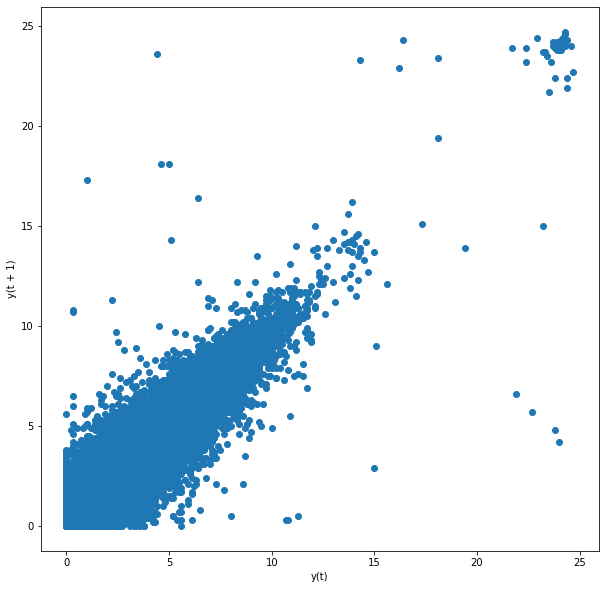

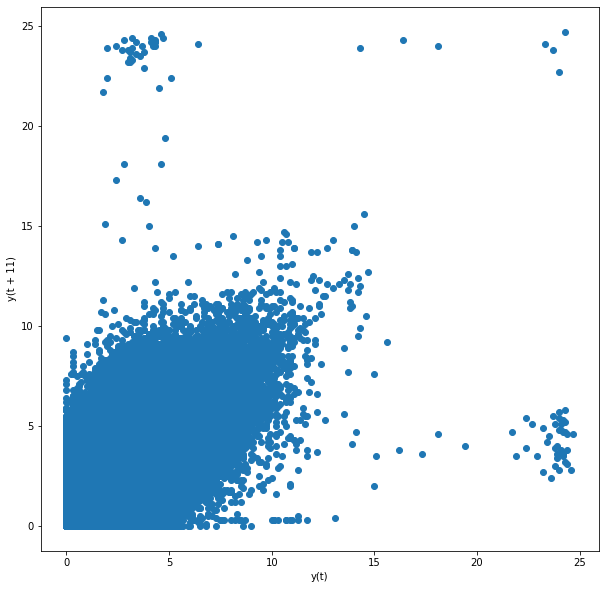

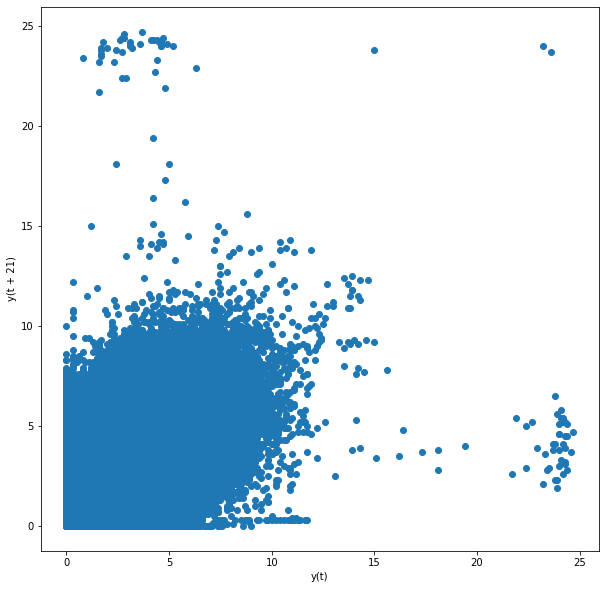

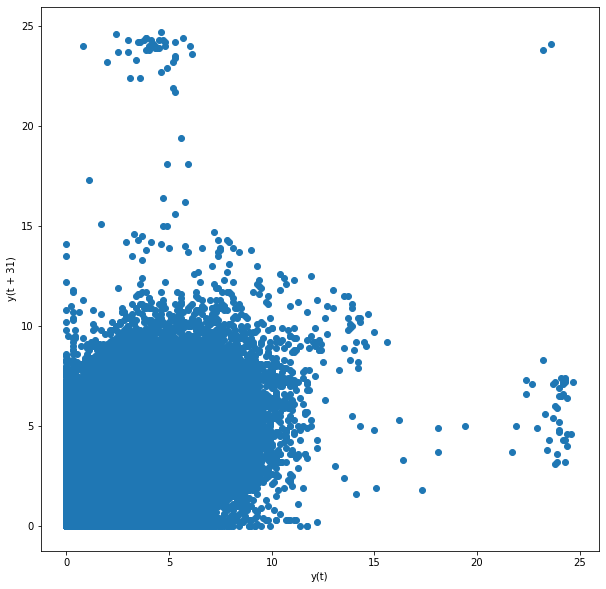

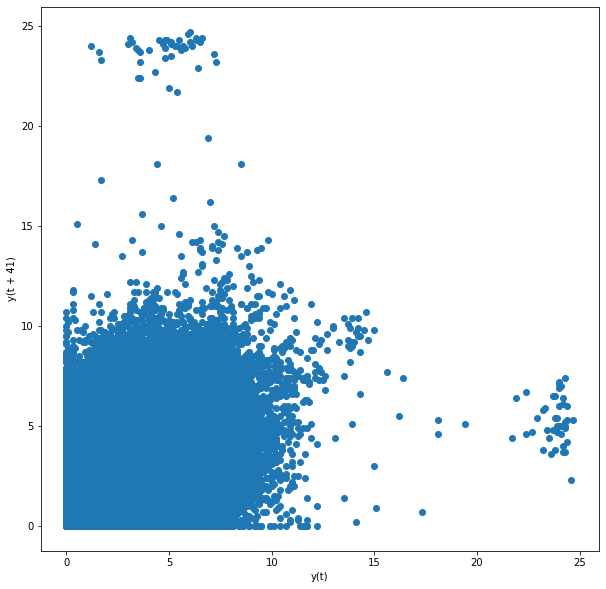

In [18]:
y = data[["speed"]]
for i in range(1, 50, 10):
    lag_plot(y, lag = i)
    plt.rcParams["figure.figsize"] = (10,10)
    pyplot.show()

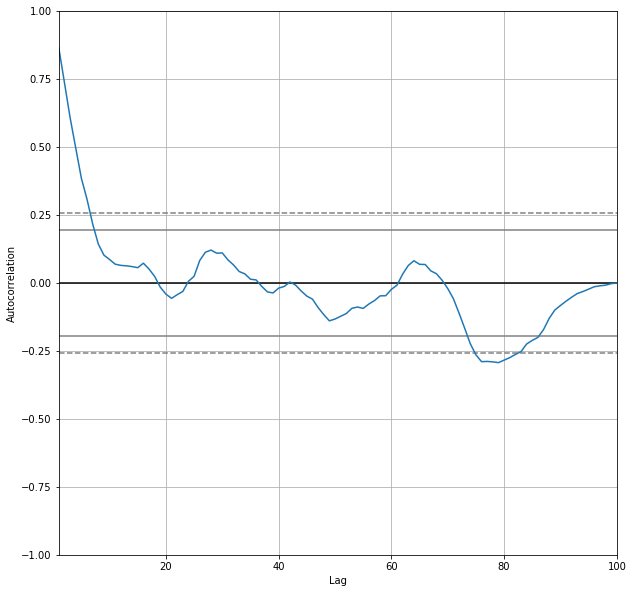

In [21]:
n = 500
autocorrelation_plot(y.head(4000).tail(100))
plt.rcParams["figure.figsize"] = (10,10)
pyplot.show()

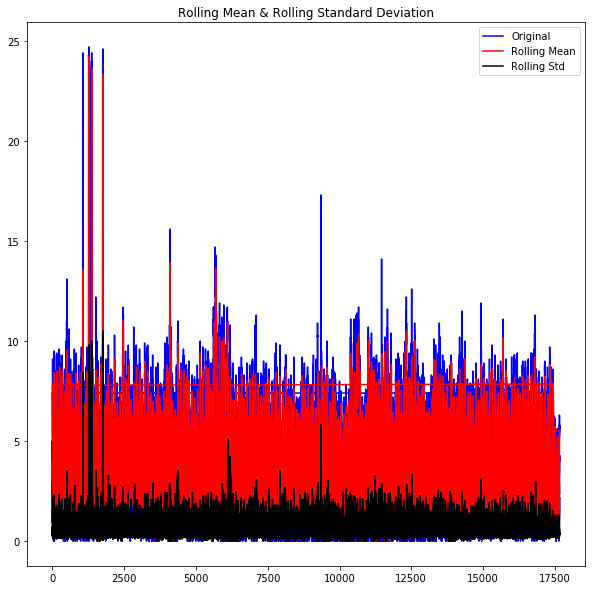

In [113]:
rolling_mean = y.rolling(window = 12).mean()
rolling_std = y.rolling(window = 12).std()
plt.plot(y, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [22]:
decomposition = seasonal_decompose(y1) 
model = ARIMA(y, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

NameError: name 'seasonal_decompose' is not defined

# LSTM

I started to write some code for an LSTM prediction, but it needs to be adapted to our format.

In [28]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import numpy as np

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: dlopen(/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/tensorflow_core/pytho

TypeError: can only concatenate str (not "list") to str

In [29]:
#w = np.array(data["wind_dir"])
cos = np.array(data["cos_wind_dir"])
sin = np.sin(data["sin_wind_dir"])#[:150000]

In [30]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

n = 256

# define input sequence
in_seq1 = np.array(data["speed"])[:n]
in_seq2 = np.array(data["cos_wind_dir"])[:n]
in_seq3 = np.sin(data["sin_wind_dir"])[:n]

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3))
# choose a number of time steps
n_steps_in, n_steps_out = 8, 4
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-b2307f1582b4>", line 27, in <module>
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 5067, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'Series' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 

AttributeError: 'Series' object has no attribute 'reshape'

In [181]:
# the dataset knows the number of features
n_features = X.shape[2]
# define model
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))#, activation='softmax')))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)

In [182]:
test1 = np.array(data["speed"])[n:n+n_steps_in]

w = np.array(data["wind_dir"])
cos = np.cos(w*2*np.pi/360)[n:n+n_steps_in]
sin = np.sin(w*2*np.pi/360)[n:n+n_steps_in]

test2 = cos
test3 = sin
# convert to [rows, columns] structure
test1 = test1.reshape((len(test1), 1))
test2 = test2.reshape((len(test2), 1))
test3 = test3.reshape((len(test3), 1))
test = hstack((test1, test2, test3))

true1 = np.array(data["speed"])[n+n_steps_in:n+n_steps_in + n_steps_out]
true2 = np.cos(w*2*np.pi/360)[n+n_steps_in:n+n_steps_in+n_steps_out]
true3 = np.sin(w*2*np.pi/360)[n+n_steps_in:n+n_steps_in+n_steps_out]
true1 = true1.reshape((len(true1), 1))
true2 = true2.reshape((len(true2), 1))
true3 = true3.reshape((len(true3), 1))
true = hstack((true1, true2, true3))
print(test)

[[ 7.60000000e+00  8.09016994e-01 -5.87785252e-01]
 [ 7.00000000e+00  7.07106781e-01 -7.07106781e-01]
 [ 7.10000000e+00  6.81998360e-01 -7.31353702e-01]
 [ 6.50000000e+00  7.31353702e-01 -6.81998360e-01]
 [ 5.10000000e+00  9.97564050e-01 -6.97564737e-02]
 [ 5.40000000e+00  1.00000000e+00 -2.44929360e-16]
 [ 5.50000000e+00  9.87688341e-01  1.56434465e-01]
 [ 4.70000000e+00  9.13545458e-01 -4.06736643e-01]]


In [183]:
# demonstrate prediction
x_input = test
x_input = x_input.reshape((1, n_steps_in, n_features))
print(x_input)
yhat = model.predict(x_input, verbose=0)
print(true)
print(yhat)

[[[ 7.60000000e+00  8.09016994e-01 -5.87785252e-01]
  [ 7.00000000e+00  7.07106781e-01 -7.07106781e-01]
  [ 7.10000000e+00  6.81998360e-01 -7.31353702e-01]
  [ 6.50000000e+00  7.31353702e-01 -6.81998360e-01]
  [ 5.10000000e+00  9.97564050e-01 -6.97564737e-02]
  [ 5.40000000e+00  1.00000000e+00 -2.44929360e-16]
  [ 5.50000000e+00  9.87688341e-01  1.56434465e-01]
  [ 4.70000000e+00  9.13545458e-01 -4.06736643e-01]]]
[[ 5.2         0.9998477  -0.01745241]
 [ 5.7         0.98162718  0.190809  ]
 [ 5.1         0.93969262 -0.34202014]
 [ 5.5         0.99939083 -0.0348995 ]]
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


In [ ]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/